In [1]:
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

# Téléchargement des ressources NLTK (uniquement la première fois)
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

# Configuration de base pour les graphiques
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
stop_words = set(stopwords.words('english'))

In [2]:
# 1. Chargement et Exploration Initiale
train_df = pd.read_csv("data/emotions_train.csv")
test_df = pd.read_csv("data/emotions_test.csv")

# Standardisation des noms de colonnes
train_df.columns = ['text', 'emotion']
test_df = test_df.rename(columns={'content': 'text', 'sentiment': 'emotion'})
test_df = test_df[['text', 'emotion']]

print("--- Informations sur le jeu de données d'entraînement ---")
train_df.info()

print("\n--- Informations sur le jeu de données de test ---")
test_df.info()

print("\n--- Premières lignes du jeu de données d'entraînement ---")
display(train_df.head())

--- Informations sur le jeu de données d'entraînement ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     21459 non-null  object
 1   emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB

--- Informations sur le jeu de données de test ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     40000 non-null  object
 1   emotion  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB

--- Premières lignes du jeu de données d'entraînement ---


,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


C:\Users\AZERTY\AppData\Local\Temp\ipykernel_13324\752462647.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=train_df['emotion'], order=train_df['emotion'].value_counts().index, palette='viridis')


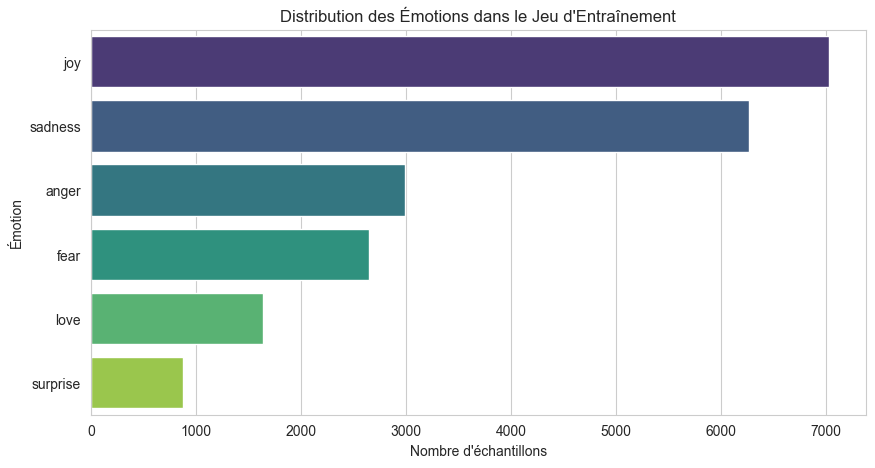

Distribution détaillée des émotions :
joy         32.755487
sadness     29.195209
anger       13.947528
fear        12.358451
love         7.647141
surprise     4.096183
Name: emotion, dtype: float64


In [3]:
# 2. Analyse de la Variable Cible (Émotions)
plt.figure(figsize=(10, 5))
sns.countplot(y=train_df['emotion'], order=train_df['emotion'].value_counts().index, palette='viridis')
plt.title("Distribution des Émotions dans le Jeu d'Entraînement")
plt.xlabel("Nombre d'échantillons")
plt.ylabel("Émotion")
plt.show()

print("Distribution détaillée des émotions :")
print(train_df['emotion'].value_counts(normalize=True) * 100)

In [4]:
# 3. Nettoyage et Prétraitement du Texte
def preprocess_text(text):
    """Nettoie et prétraite le texte pour l'analyse NLP."""
    if pd.isna(text):
        return ""
    
    # Conversion en minuscules
    text = text.lower()
    # Suppression des mentions, URLs, et hashtags
    text = re.sub(r'@\w+|http\S+|www\S+|#\w+', '', text)
    # Suppression des caractères HTML
    text = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', text)
    # Suppression de la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Suppression des chiffres
    text = re.sub(r'\d+', '', text)
    # Suppression des espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()
    # Suppression des stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    return text

print("Application du nettoyage et prétraitement sur les textes...")
train_df['text_clean'] = train_df['text'].apply(preprocess_text)
test_df['text_clean'] = test_df['text'].apply(preprocess_text)

# Suppression des lignes où le texte nettoyé est vide
train_df = train_df[train_df['text_clean'].str.len() > 0]
test_df = test_df[test_df['text_clean'].str.len() > 0]

print("Nettoyage terminé. Affichage des textes avant et après :")
display(train_df[['text', 'text_clean']].head())

Application du nettoyage et prétraitement sur les textes...
Nettoyage terminé. Affichage des textes avant et après :
Nettoyage terminé. Affichage des textes avant et après :


,text,text_clean
0,i didnt feel humiliated,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,feeling grouchy


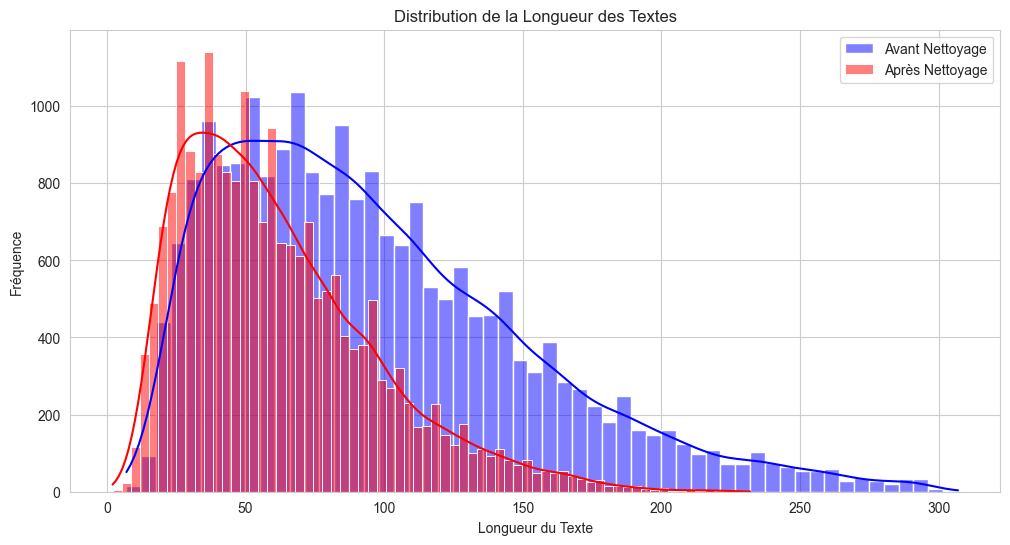

Statistiques sur la longueur des textes :


,text_len,text_clean_len
count,21458.000000,21458.000000
mean,96.715957,61.592879
std,55.383719,34.997205
min,7.000000,2.000000
25%,53.250000,35.000000
50%,86.000000,54.000000
75%,129.000000,81.000000
max,307.000000,232.000000


In [5]:
# 4. Analyse Approfondie : Longueur des Textes
train_df['text_len'] = train_df['text'].str.len()
train_df['text_clean_len'] = train_df['text_clean'].str.len()

plt.figure(figsize=(12, 6))
sns.histplot(train_df['text_len'], color='blue', label='Avant Nettoyage', kde=True)
sns.histplot(train_df['text_clean_len'], color='red', label='Après Nettoyage', kde=True)
plt.title('Distribution de la Longueur des Textes')
plt.xlabel('Longueur du Texte')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

print("Statistiques sur la longueur des textes :")
display(train_df[['text_len', 'text_clean_len']].describe())

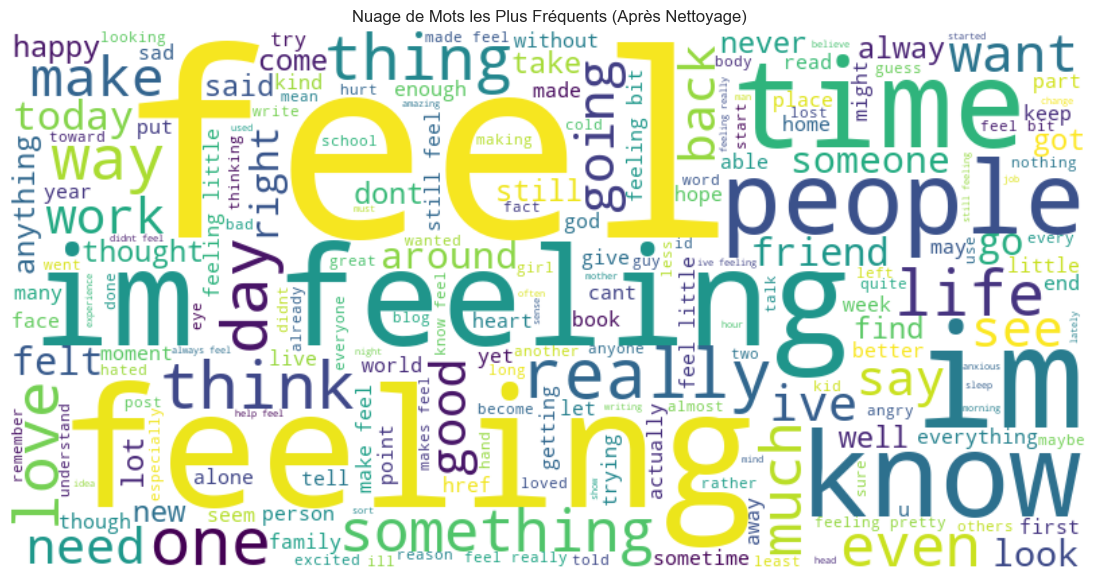

In [6]:
# 5. Visualisation : Nuage de Mots
all_words = ' '.join(train_df['text_clean'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de Mots les Plus Fréquents (Après Nettoyage)')
plt.show()

C:\Users\AZERTY\AppData\Local\Temp\ipykernel_13324\1335180803.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Fréquence', y='Mot', data=word_df, palette='cividis')


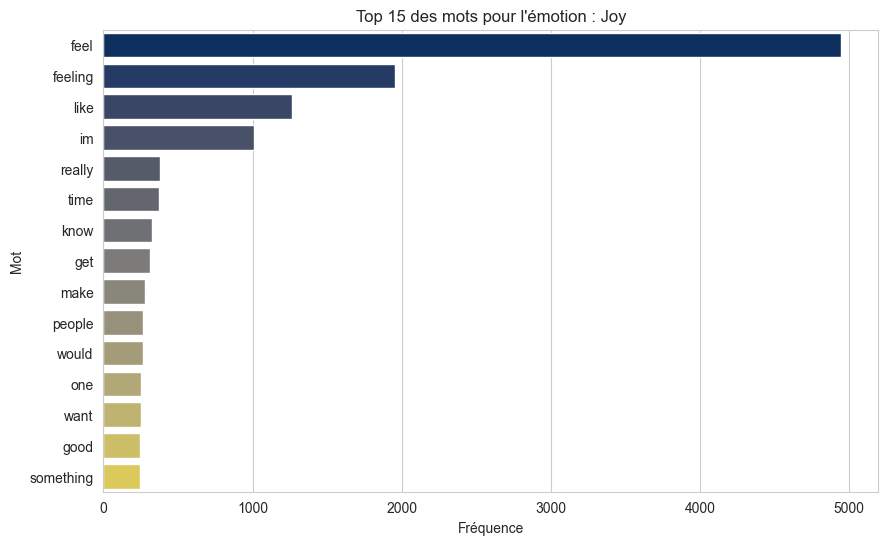

C:\Users\AZERTY\AppData\Local\Temp\ipykernel_13324\1335180803.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Fréquence', y='Mot', data=word_df, palette='cividis')


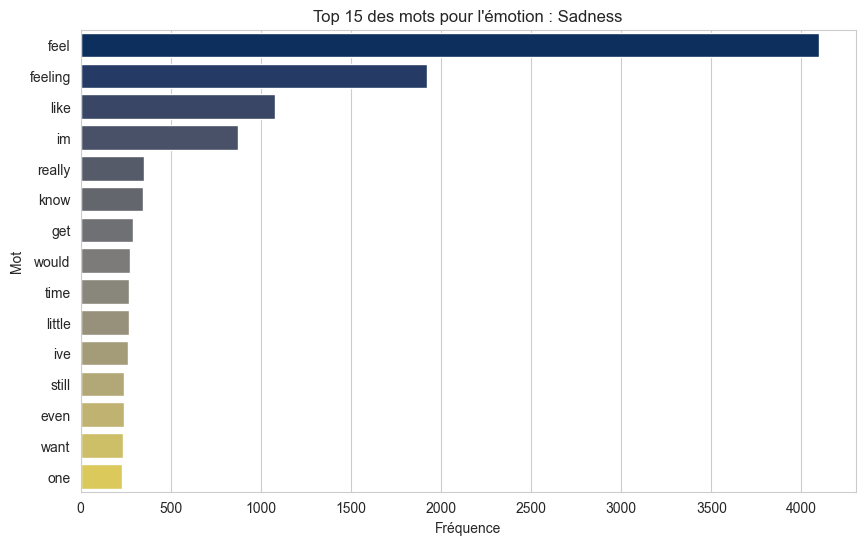

C:\Users\AZERTY\AppData\Local\Temp\ipykernel_13324\1335180803.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Fréquence', y='Mot', data=word_df, palette='cividis')


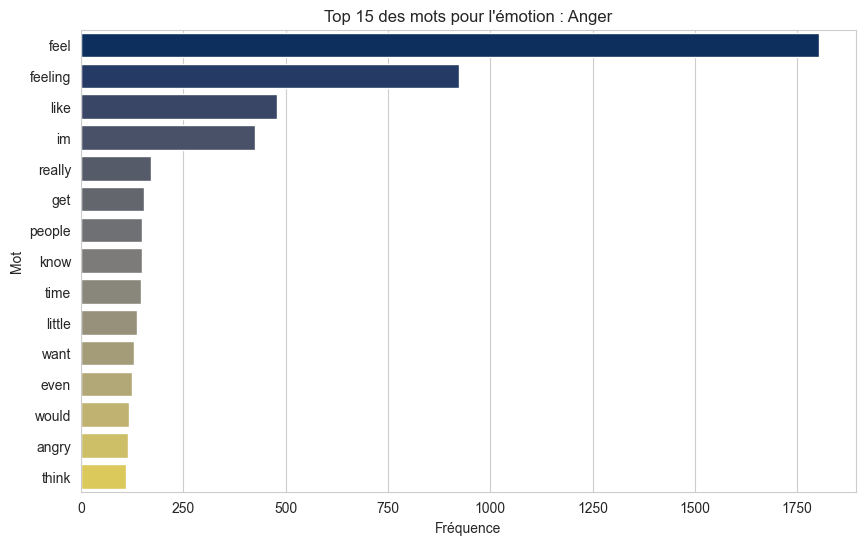

C:\Users\AZERTY\AppData\Local\Temp\ipykernel_13324\1335180803.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Fréquence', y='Mot', data=word_df, palette='cividis')


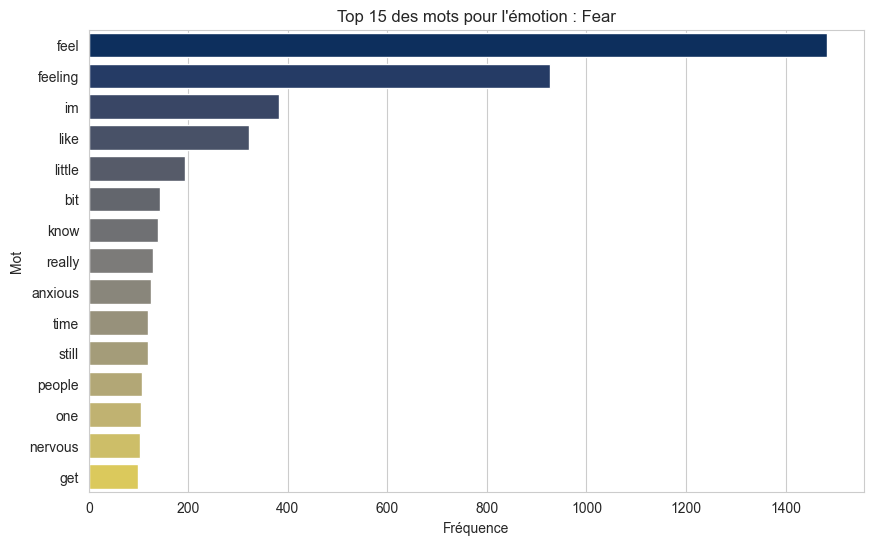

In [7]:
# Analyse de la fréquence des mots par émotion
def plot_top_words_by_emotion(df, emotion, n=15):
    """Affiche les mots les plus fréquents pour une émotion donnée."""
    plt.figure(figsize=(10, 6))
    corpus = df[df['emotion'] == emotion]['text_clean']
    word_freq = Counter(" ".join(corpus).split()).most_common(n)
    word_df = pd.DataFrame(word_freq, columns=['Mot', 'Fréquence'])
    
    sns.barplot(x='Fréquence', y='Mot', data=word_df, palette='cividis')
    plt.title(f"Top {n} des mots pour l'émotion : {emotion.capitalize()}")
    plt.show()

# Affichage pour les émotions principales
main_emotions = train_df['emotion'].value_counts().index[:4]
for emotion in main_emotions:
    plot_top_words_by_emotion(train_df, emotion)

In [8]:
# 6. Sauvegarde des Données Traitées
# Sélection des colonnes pertinentes
train_final = train_df[['text_clean', 'emotion']]
test_final = test_df[['text_clean', 'emotion']]

# Renommage pour la clarté
train_final.columns = ['text', 'emotion']
test_final.columns = ['text', 'emotion']

# Sauvegarde
train_final.to_csv("data/emotions_train_clean.csv", index=False)
test_final.to_csv("data/emotions_test_clean.csv", index=False)

print("Données nettoyées et traitées sauvegardées avec succès.")
print(f"Jeu d'entraînement : {train_final.shape[0]} lignes")
print(f"Jeu de test : {test_final.shape[0]} lignes")

print("\nAperçu des données finales :")
display(train_final.head())

Données nettoyées et traitées sauvegardées avec succès.
Jeu d'entraînement : 21458 lignes
Jeu de test : 39775 lignes

Aperçu des données finales :


,text,emotion
0,didnt feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger


# 7. Modélisation avec PyCaret

Maintenant que nos données sont nettoyées et prêtes, nous allons utiliser PyCaret pour automatiser le processus d'entraînement et d'évaluation de plusieurs modèles de classification.

In [9]:
from pycaret.nlp import *

# Charger les données nettoyées
data = pd.read_csv('data/emotions_train_clean.csv')

# Configuration de l'environnement PyCaret
nlp_setup = setup(data=data, target='text', session_id=123)

ModuleNotFoundError: No module named 'pycaret.nlp'

In [ ]:
# Création d'un modèle de Topic Modeling (LDA)
lda = create_model('lda')
print(lda)

In [ ]:
# Assignation des topics
lda_results = assign_model(lda)
lda_results.head()

In [ ]:
# Visualisation des résultats
plot_model(lda, plot='topic_distribution')